In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [1]:
import os
import kagglehub
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Download the dataset
path = kagglehub.dataset_download("jagdishchakole1/mango-data")
print("Path to dataset files:", path)

# Define data directories
train_dir = os.path.join(path, "Mango_leaf_disease1/train")
val_dir = os.path.join(path, "Mango_leaf_disease1/val")
test_dir = os.path.join(path, "Mango_leaf_disease1/test")

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=25,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

Path to dataset files: /kaggle/input/mango-data


In [2]:
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Set up the generators
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(299, 299),  # InceptionV3 requires 299x299 input
    batch_size=32,
    class_mode='categorical'
)
val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(299, 299),
    batch_size=32,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(299, 299),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

# Get the number of classes
num_classes = len(train_generator.class_indices)
print(f"Number of classes: {num_classes}")
print("Class mapping:", train_generator.class_indices)

Found 2800 images belonging to 8 classes.
Found 800 images belonging to 8 classes.
Found 400 images belonging to 8 classes.
Number of classes: 8
Class mapping: {'Anthracnose': 0, 'Bacterial Canker': 1, 'Cutting Weevil': 2, 'Die Back': 3, 'Gall Midge': 4, 'Healthy': 5, 'Powdery Mildew': 6, 'Sooty Mould': 7}


In [3]:
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(299, 299, 3))

# Freeze the base model layers
for layer in base_model.layers:
    layer.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)  # Add dropout to prevent overfitting
predictions = Dense(num_classes, activation='softmax')(x)

# Create the final model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [4]:
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=3,
    min_lr=1e-6
)

# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=15,
    validation_data=val_generator,
    validation_steps=val_generator.samples // val_generator.batch_size,
    callbacks=[early_stopping, reduce_lr]
)

Epoch 1/15


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


87/87 ━━━━━━━━━━━━━━━━━━━━ 115s 1s/step - accuracy: 0.5487 - loss: 1.3367 - val_accuracy: 0.9212 - val_loss: 0.3628 - learning_rate: 1.0000e-04
Epoch 2/15
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 657us/step - accuracy: 0.9375 - loss: 0.3168 - learning_rate: 1.0000e-04
Epoch 3/15


/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)
/usr/local/lib/python3.10/dist-packages/keras/src/callbacks/early_stopping.py:155: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: accuracy,loss
  current = self.get_monitor_value(logs)
/usr/local/lib/python3.10/dist-packages/keras/src/callbacks/callback_list.py:96: UserWarning: Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: accuracy,loss,learning_rate.
  callback.on_epoch_end(epoch, logs)


87/87 ━━━━━━━━━━━━━━━━━━━━ 63s 667ms/step - accuracy: 0.9110 - loss: 0.3224 - val_accuracy: 0.9337 - val_loss: 0.2149 - learning_rate: 1.0000e-04
Epoch 4/15
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 257us/step - accuracy: 1.0000 - loss: 0.1594 - learning_rate: 1.0000e-04
Epoch 5/15
87/87 ━━━━━━━━━━━━━━━━━━━━ 63s 667ms/step - accuracy: 0.9400 - loss: 0.2159 - val_accuracy: 0.9337 - val_loss: 0.2044 - learning_rate: 1.0000e-04
Epoch 6/15
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 231us/step - accuracy: 0.9688 - loss: 0.2381 - learning_rate: 1.0000e-04
Epoch 7/15
87/87 ━━━━━━━━━━━━━━━━━━━━ 63s 672ms/step - accuracy: 0.9477 - loss: 0.1720 - val_accuracy: 0.9500 - val_loss: 0.1406 - learning_rate: 1.0000e-04
Epoch 8/15
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 237us/step - accuracy: 0.9688 - loss: 0.0980 - learning_rate: 1.0000e-04
Epoch 9/15
87/87 ━━━━━━━━━━━━━━━━━━━━ 62s 658ms/step - accuracy: 0.9665 - loss: 0.1274 - val_accuracy: 0.9550 - val_loss: 0.1318 - learning_rate: 1.0000e-04
Epoch 10/15
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s

In [5]:
test_loss, test_acc = model.evaluate(test_generator)
print(f"Test accuracy: {test_acc:.4f}")

# Save the model
model.save('mango_disease_inception_model.h5')


13/13 ━━━━━━━━━━━━━━━━━━━━ 7s 594ms/step - accuracy: 0.9824 - loss: 0.0590
Test accuracy: 0.9725


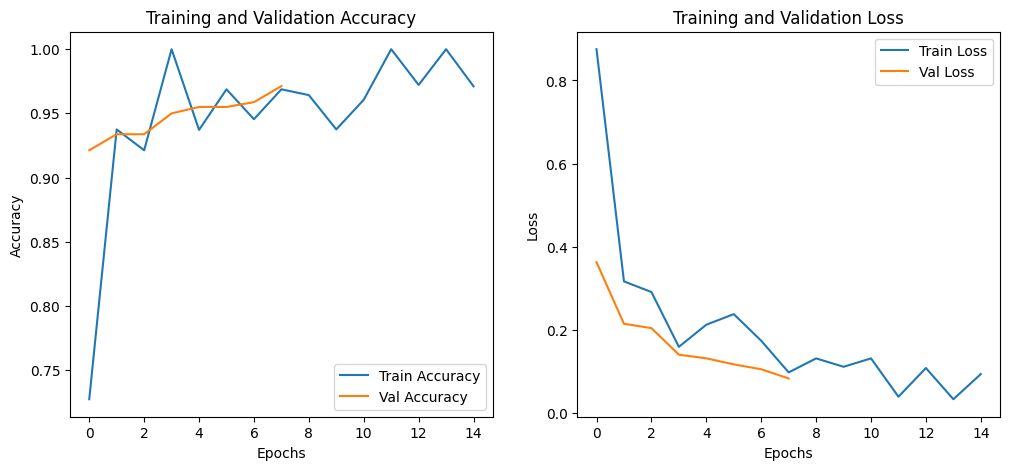

Test accuracy after fine-tuning: 0.9725


In [6]:
def plot_history(history):
    plt.figure(figsize=(12, 5))

    # Plot accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Val Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Training and Validation Accuracy')

    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training and Validation Loss')

    plt.show()

plot_history(history)

print(f"Test accuracy after fine-tuning: {test_acc:.4f}")